# Fine-Tuning BERT with Fast AI
 > Ref: http://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/

## Import Libs

In [9]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [10]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [35]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=True,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=1,
    use_fp16=False,
    bs=4,
    discriminative=False,
    max_seq_len=128,
)

In [36]:
config.keys()

dict_keys(['testing', 'bert_model_name', 'max_lr', 'epochs', 'use_fp16', 'bs', 'discriminative', 'max_seq_len'])

## Preprocssing BERT tokenizer

In [1]:
!pip install pytorch-pretrained-bert

In [2]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(config.bert_model_name)

100%|██████████| 231508/231508 [00:01<00:00, 175577.32B/s]


In [7]:
bert_tok.max_len

512

In [28]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer:BertTokenizer, max_seq_len:int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    def __call__(self, *args, **kwargs):
        return self
    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [29]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [30]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

## Data

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
DATA_ROOT = Path("/home/inesa/data/kaggle/jigsaw")

In [37]:
train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test.csv"]]
train, val = train_test_split(train)
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [38]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
32066,5535212ea0ad1c0e,"""\n\n You have been blocked from editing for...",0,0,0,0,0,0
60784,a2b49db0e6b69ead,10 Y \n\nShould you be compared to Katrina ? . -),0,0,0,0,0,0
77423,cf6da120cc875ae6,"""\n\n No consensus, no resolution \n\nEveryone...",0,0,0,0,0,0
114335,638c527e2d3e4cfe,Judging from your talk page and your recent ed...,0,0,0,0,0,0
55537,9468066c2091a3b3,"""== Inconsistent capitalization ==\nProper nam...",0,0,0,0,0,0


In [39]:
train.shape

(1024, 8)

In [40]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
databunch = TextDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

Notice we're passing the include_bos=False and include_eos=False options. This is to prevent fastai from adding its own SOS/EOS tokens that will interfere with BERT's SOS/EOS tokens.

### Another method for preprocessors to the databunch

In [32]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [33]:

class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [ ]:

# this will produce a virtually identical databunch to the code above
# databunch = BertDataBunch.from_df(".", train, val, test,
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_bert_vocab,
#                   text_cols="comment_text",
#                   label_cols=label_cols,
#                   bs=config.bs,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
#              )

## Model Define

In [41]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

100%|██████████| 407873900/407873900 [05:45<00:00, 1179811.97B/s]


Since this is a multilabel classification problem, we're using BCEWithLogitsLoss

In [42]:
loss_func = nn.BCEWithLogitsLoss()

In [43]:
learner = Learner(databunch, bert_model, loss_func=loss_func)

## Train the Model

In [44]:
if config.use_fp16: learner = learner.to_fp16()

In [45]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


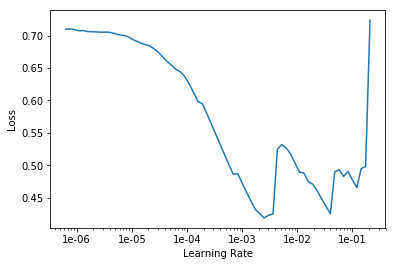

In [46]:
learner.recorder.plot()

In [47]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.094217,0.090613,05:34


## Predictions

In [48]:

def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [49]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [50]:
test_preds

array([[0.629963, 0.201301, 0.401476, 0.223633, 0.414276, 0.171006],
       [0.047237, 0.020264, 0.030383, 0.019383, 0.029055, 0.021044],
       [0.047901, 0.020286, 0.031082, 0.019709, 0.029375, 0.021309],
       [0.044037, 0.027696, 0.03132 , 0.021201, 0.031414, 0.025988],
       ...,
       [0.300356, 0.057347, 0.147534, 0.050955, 0.132782, 0.042851],
       [0.590388, 0.171643, 0.324191, 0.188688, 0.357483, 0.160373],
       [0.084112, 0.022294, 0.041948, 0.019052, 0.047608, 0.020202],
       [0.567621, 0.140828, 0.308364, 0.149693, 0.325495, 0.120871]], dtype=float32)

## Submission

In [51]:
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")
if config.testing: sample_submission = sample_submission.head(test.shape[0])
sample_submission[label_cols] = test_preds
sample_submission.to_csv("predictions.csv", index=False)